# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2018

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos que hacen uso de modelos matematicos para aproximar una funcion de valor.

## CartPole: Agente aleatorio

In [3]:
import gym
import time
from IPython.display import clear_output

env = gym.make('CartPole-v0')
env.reset()
for _ in range(500):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

## CartPole: Aproximación con un modelo lineal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from agents.cart_pole_approx_vf import CartPole_SGD
import itertools

agent = CartPole_SGD.SGDCartPoleSolver()
scores = agent.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[Episode 0] - Mean survival time over last 100 episodes was 14.0 ticks.


/home/ezequiel/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[Episode 100] - Mean survival time over last 100 episodes was 17.07 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 13.82 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 10.82 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 10.33 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 9.94 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 9.65 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 9.8 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 9.39 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 9.48 ticks.


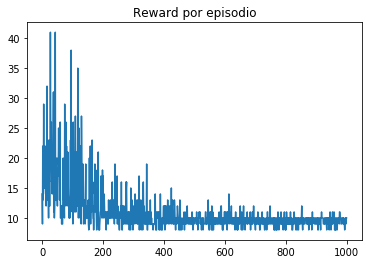

In [3]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores))), np.array(scores))
plt.title('Reward por episodio')
plt.show()

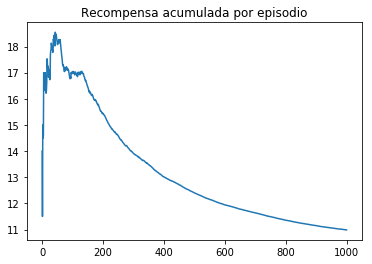

In [4]:
# se suaviza la curva de convergencia
episode_number = np.linspace(1, len(scores) + 1, len(scores) + 1)
acumulated_rewards = np.cumsum(scores)

reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

plt.plot(reward_per_episode)
plt.title('Recompensa acumulada por episodio')
plt.show()

## CartPole: Aproximación con Redes Neuronales

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from agents.cart_pole_approx_vf import CartPole_DQN
import itertools

agent = CartPole_DQN.DQNCartPoleSolver()
scores = agent.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[Episode 0] - Mean survival time over last 100 episodes was 10.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 11.87 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 25.69 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 46.53 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 76.25 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 105.14 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 137.24 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 171.59 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 198.41 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 197.69 ticks.


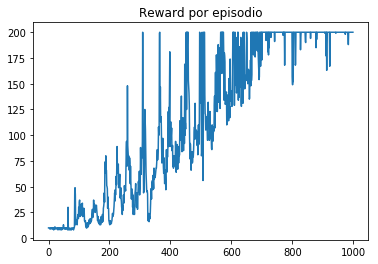

In [16]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores))), np.array(scores))
plt.title('Reward por episodio')
plt.show()

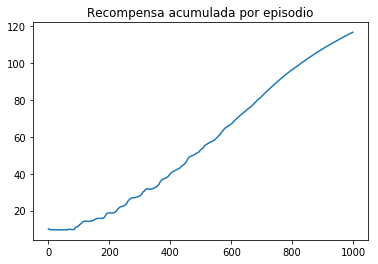

In [19]:
# se suaviza la curva de convergencia
episode_number = np.linspace(1, len(scores) + 1, len(scores) + 1)
acumulated_rewards = np.cumsum(scores)

reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

plt.plot(reward_per_episode)
plt.title('Recompensa acumulada por episodio')
plt.show()